In [1]:
setwd("../")
source("Unico.r") #core algorithm   
source("./Tutorial/helper.r")#for evaluation
library("MASS")

set.seed(2023)


Attaching package: ‘config’


The following objects are masked from ‘package:base’:

    get, merge


Loading required package: nlme

This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.


Attaching package: ‘mgcv’


The following object is masked from ‘package:pracma’:

    magic



Attaching package: ‘futile.logger’


The following object is masked from ‘package:mgcv’:

    scat


Warning message:
“package ‘MASS’ was built under R version 4.1.3”


# Load data

In [2]:
# data simulated using real single-cell PBMC from Stephenson et al. as described in the Method section
sim.data = readRDS("Tutorial/tutorial.data.rds")

In [3]:
str(sim.data)

List of 13
 $ source.ids             : chr [1:5] "CD4" "NK" "CD8" "Mono" ...
 $ feature.ids            : chr [1:600] "AP2M1" "RASGRP4" "KIAA0319L" "IFT22" ...
 $ sample.ids             : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
 $ W                      : num [1:500, 1:5] 0.402 0.27 0.218 0.431 0.334 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
  .. ..$ : chr [1:5] "CD4" "NK" "CD8" "Mono" ...
 $ Z                      : num [1:5, 1:600, 1:500] 54.3 66.4 58.7 18.2 44.7 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:5] "CD4" "NK" "CD8" "Mono" ...
  .. ..$ : chr [1:600] "AP2M1" "RASGRP4" "KIAA0319L" "IFT22" ...
  .. ..$ : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
 $ X                      : num [1:600, 1:500] 53.925 0.246 10.779 2.049 2.559 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:600] "AP2M1" "RASGRP4" "KIAA0319L" "IFT22" ...
  .. ..$ : chr [1:500] "sample.1"

# Run deconvolution

In [4]:
unico.mdl = list()

#parameter learning 
unico.mdl$params.hat <- Unico(sim.data$X, sim.data$W, C1 = NULL, C2 = NULL, parallel = TRUE, log_file = "Tutorial/Unico.log")
#capping extreme values
unico.mdl$params.hat$sigmas_hat = cap_values(unico.mdl$params.hat$sigmas_hat,  max.val = 10 ** (4), min.val = 10**(-4))

#tensor 
unico.mdl$Z.hat = tensor(sim.data$X, W = sim.data$W, C1 = NULL, C2 = NULL, 
                         unico.mdl$params.hat, parallel = FALSE, log_file = "Tutorial/Unico.log")


INFO [2023-11-07 23:25:47] Starting Unico...
INFO [2023-11-07 23:25:48] Starting parameter learning ...
INFO [2023-11-07 23:25:48] Initiate cluster...
INFO [2023-11-07 23:25:48] Parallel is on with 12 nodes.
INFO [2023-11-07 23:25:49] Packages were loaded into the cluster nodes.
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=38s  
INFO [2023-11-07 23:26:28] Stop cluster
INFO [2023-11-07 23:26:28] Formating results ...
INFO [2023-11-07 23:26:28] Finished parameter learning
[1] "there are extrmemely close to 0 values: 53"
INFO [2023-11-07 23:26:28] Starting tensor ...
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  
INFO [2023-11-07 23:26:32] Formating tensor result...
INFO [2023-11-07 23:26:32] Finished tensor estimation


In [5]:
# estimated cell-type levels is an array that is cell types by genes by samples
str(unico.mdl$Z.hat)

 num [1:5, 1:600, 1:500] 37.8 76.3 72.6 47.3 51.4 ...
 - attr(*, "dimnames")=List of 3
  ..$ : chr [1:5] "CD4" "NK" "CD8" "Mono" ...
  ..$ : chr [1:600] "AP2M1" "RASGRP4" "KIAA0319L" "IFT22" ...
  ..$ : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...


In [6]:
# evaluate tensor performance on features with variation 
unico.mdl$Z.corrs = calc_Z_corrs(Z.true = sim.data$Z.scale,
                                 Z.hat  = unico.mdl$Z.hat, 
                                 eval.feature.source = sim.data$variable.feature.source) 

In [7]:
head(unico.mdl$Z.corrs)

,CD4,NK,CD8,Mono,B
AP2M1,0.9420903,0.9006382,0.9116919,0.8126801,0.8614461
RASGRP4,0.1507470,0.1839195,0.1027680,0.7952123,0.1523983
KIAA0319L,0.8295373,0.7975428,0.7879739,0.7194958,0.5737766
IFT22,0.7343705,0.5411252,0.5152420,0.3469622,0.6292864
TEX261,0.9335837,0.8325365,0.8820728,0.7806502,0.7479916
BZW2,0.8415181,0.7253845,0.7343401,0.4232661,0.6180740


In [8]:
colMedians(unico.mdl$Z.corrs)

[1] 0.8612621 0.7708118 0.7875883 0.5838347 0.6579529

# Visualize a random low entropy gene

In [9]:
low.gene = sample(rownames(sim.data$params$entropies[sim.data$params$entropies <
                                                     quantile(sim.data$params$entropies, 0.25), ,drop= F]), 1)

integer(0)

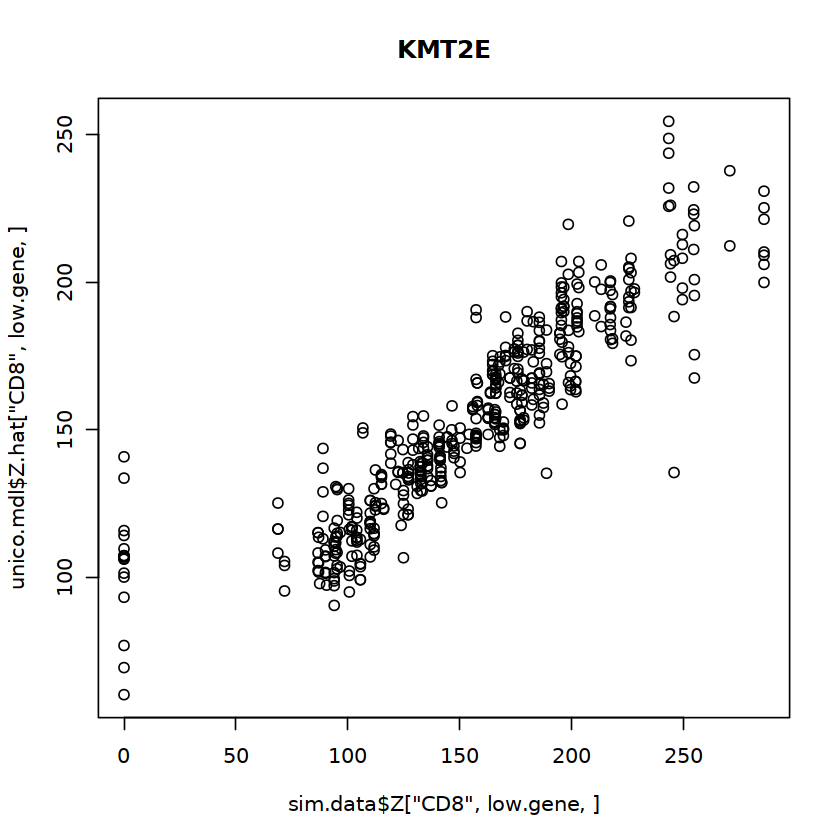

In [10]:
plot(sim.data$Z["CD8",low.gene, ], unico.mdl$Z.hat["CD8",low.gene, ]) + title (low.gene)

# Compare with TCA, which does not model cross celltype covariance 

In [11]:
library("TCA")


Attaching package: ‘TCA’


The following object is masked _by_ ‘.GlobalEnv’:

    tensor




In [12]:
tca.mdl = list()
    
#provide the data already standardized by std
tca.mdl$params.hat <- tca(sim.data$X.scale, sim.data$W, constrain_mu = TRUE, log_fil=NULL)
#capping extreme values
tca.mdl$params.hatl$sigmas_hat = cap_values(tca.mdl$params.hat$sigmas_hat, max.val = 10**(4), min.val = 10**(-4))

# tensor 
tca.mdl$Z.hat = TCA::tensor(sim.data$X.scale, tca.mdl$params.hat, log_fil=NULL)
tca.mdl$Z.hat = list_2_array(tca.mdl$Z.hat, colnames(sim.data$W))   
tca.mdl$Z.hat = scale_feature_source_source(tca.mdl$Z.hat, sim.data$feature.scale.factor)

INFO [2023-11-07 23:27:45] Starting tca...
INFO [2023-11-07 23:27:45] Validating input...
INFO [2023-11-07 23:27:45] Fitting the TCA model...
INFO [2023-11-07 23:27:45] Fitting means and variances...
INFO [2023-11-07 23:27:45] Iteration 1 out of 10 internal iterations...
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
INFO [2023-11-07 23:27:45] Iteration 2 out of 10 internal iterations...
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
INFO [2023-11-07 23:27:46] Internal loop converged.
INFO [2023-11-07 23:27:46] Finished tca.
INFO [2023-11-07 23:27:46] Validating input...
INFO [2023-11-07 23:27:46] Starting tensor for estimating Z...
INFO [2023-11-07 23:27:46] Estimate tensor...
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
INFO [2023-11-07 23:27:50] Finished estimating tensor.


In [13]:
# evaluate tensor performance on features with variation 
tca.mdl$Z.corrs = calc_Z_corrs(Z.true = sim.data$Z,
                               Z.hat  = tca.mdl$Z.hat, 
                               eval.feature.source = sim.data$variable.feature.source)

In [14]:
colMedians(tca.mdl$Z.corrs )

[1] 0.7968254 0.6950739 0.6836195 0.4678893 0.5494200

integer(0)

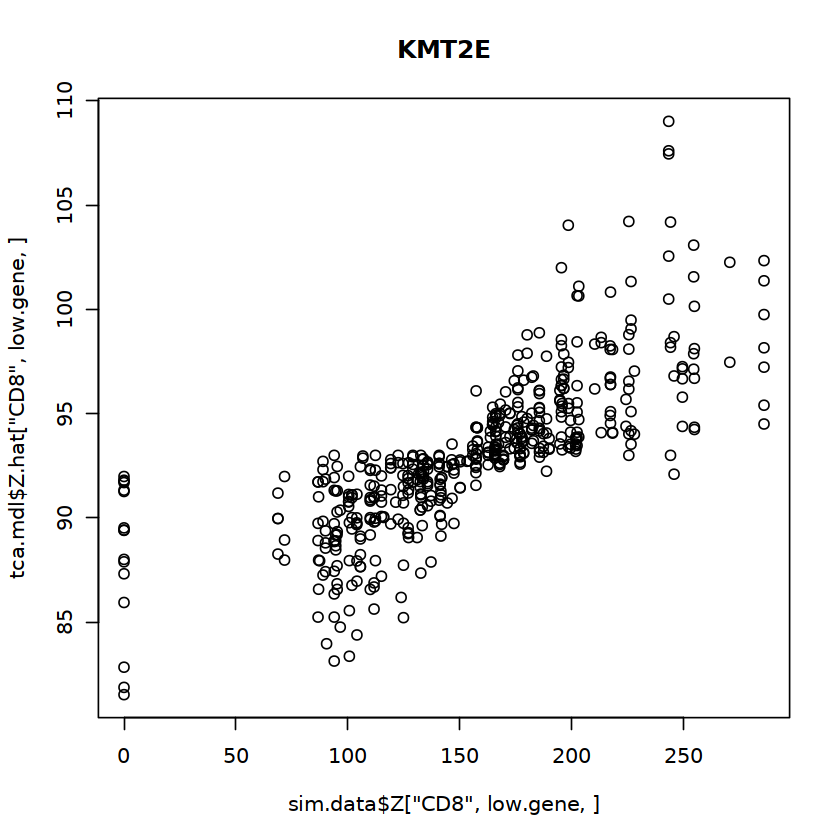

In [15]:
plot(sim.data$Z["CD8",low.gene, ], tca.mdl$Z.hat["CD8",low.gene, ]) + title (low.gene)

In [16]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /u/project/halperin/johnsonc/TCAx/envs4/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] TCA_1.2.1           MASS_7.3-57         futile.logger_1.4.3
 [4] nloptr_1.2.2.3      mgcv_1.8-38         nlme_3.1-153       
 [7] matrixcalc_1.0-5    matrixStats_0.61.0  data.table_1.14.2  
[10] testit_0.13         pracma_2.3.6        config_0.3.1       
[13] pbapply_1.5-0     